In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import HelperFunctions as hf

# Prepare Data

In [3]:
#load data
sales_df= hf.load_sales_train_validation_data()
calendar_df= hf.load_calendar_data()
prices_df= hf.load_sell_price_data()

In [4]:
#clean data
df = hf.rawToClean(sales_df, calendar_df, prices_df, days=1200, items=1000, dropNAPrices=True)

In [5]:
#add rolling mean
df = hf.rollingMeanDemandFeature(df, windowSize=7, shift=1) #Mean of previous week
df = hf.rollingMeanDemandFeature(df, windowSize=28, shift=1) #Mean of previous 28 days

df = hf.rollingMeanWeekday(df, weeks = 3, shift = 1) #mean of previous 3 weeks (for that particular weekday)

#add lag
df = hf.lagFeature(df, var='sold', lag=1) #Amount sold day before
df = hf.lagFeature(df, var='sold', lag=7) #Amount sold a week before
df = hf.lagFeature(df, var='sold', lag=28) #Amount sold 28 days before

df.dropna(inplace=True) #Drop rows with NAs (as result of lagged features)

In [6]:
product_ids = df.id.copy()
df.drop(['id'], axis=1, inplace=True) #Drop the id column

In [7]:
df.head()

,d,sold,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price,Cultural,...,WI_3,CA,TX,WI,rolling_mean_7_1,rolling_mean_28_1,rolling_mean_3_1,sold_lag_1,sold_lag_7,sold_lag_28
28002,29,0,1,2,2011,0,0,0,5.94,0,...,0,1,0,0,0.142857,0.107143,0.000000,0,0,1
28008,29,0,1,2,2011,0,0,0,4.98,0,...,0,1,0,0,1.142857,1.000000,1.333333,1,2,1
28012,29,3,1,2,2011,0,0,0,4.67,0,...,1,0,0,1,2.000000,1.821429,1.666667,1,0,3
28013,29,1,1,2,2011,0,0,0,2.27,0,...,0,0,0,1,1.142857,0.714286,0.666667,0,2,0
28014,29,1,1,2,2011,0,0,0,3.86,0,...,0,1,0,0,0.428571,0.321429,0.666667,0,1,0


# Machine Learning

In [8]:
#Standardise features
from sklearn.preprocessing import MinMaxScaler

cols_to_norm = ['d','wday','month','year','sell_price','rolling_mean_7_1','rolling_mean_28_1','sold_lag_1',
                'sold_lag_7','sold_lag_28']

df[cols_to_norm] = MinMaxScaler().fit_transform(df[cols_to_norm])

In [9]:
X=df.drop(['sold'],axis=1).values
y=df['sold'].values

In [10]:
#train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression

lm=LinearRegression()
lm.fit(X_train,y_train)
preds_test=lm.predict(X_test)
preds_train=lm.predict(X_train)

In [12]:
#error
from sklearn.metrics import mean_squared_error

print(f"MSE on train set: {mean_squared_error(preds_train,y_train)}")
print(f"MSE on test set: {mean_squared_error(preds_test,y_test)}")

MSE on train set: 6.294245370768077
MSE on test set: 6.377682757363705


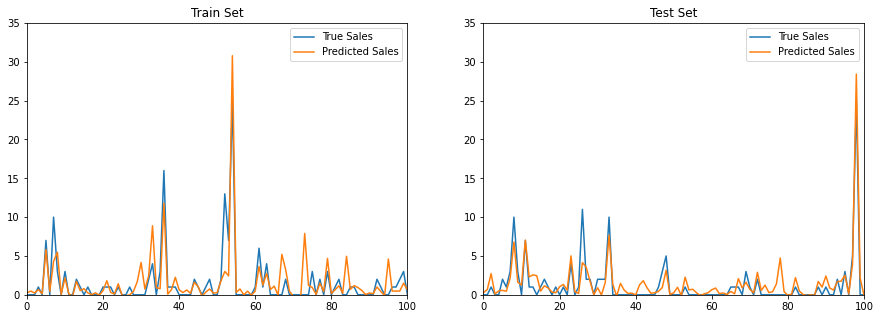

In [13]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.arange(len(y_train)), y_train, label='True Sales')
ax[0].plot(np.arange(len(preds_train)), preds_train, label='Predicted Sales')
ax[0].set_title("Train Set")
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,35)
ax[0].legend()

ax[1].plot(np.arange(len(y_test)), y_test, label='True Sales')
ax[1].plot(np.arange(len(preds_test)), preds_test, label='Predicted Sales')
ax[1].set_title("Test Set")
ax[1].set_xlim(0,100)
ax[1].set_ylim(0,35)
ax[1].legend()

plt.show()

# LightGBM (LGBM)

https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

pip install lightgbm

In [50]:
import lightgbm as lgb

model=lgb.LGBMRegressor(learning_rate=0.05,
                        boosting_type="gbdt",  
                        objective="regression",
                        metric="mse",
                        num_leaves=50,
                        max_depth=10,
                        n_estimators=100)

model.fit(X_train, y_train)

preds_train=model.predict(X_train)
preds_test=model.predict(X_test)


print(f"MSE on train set: {mean_squared_error(y_train, preds_train)}")
print(f"RMSE on train set: {mean_squared_error(y_train, preds_train)**0.5}")
print()
print(f"MSE on test set:  {mean_squared_error(y_test, preds_test)}")
print(f"RMSE on test set:  {mean_squared_error(y_test, preds_test)**0.5}")

MSE on train set: 4.927420546337538
RMSE on train set: 2.2197793913669748

MSE on test set:  5.973818383811857
RMSE on test set:  2.444139599902562


In [51]:
from sklearn.model_selection import cross_val_score

model=lgb.LGBMRegressor(learning_rate=0.05,
                        boosting_type="gbdt",  
                        objective="regression",
                        metric="mse",
                        num_leaves=50,
                        max_depth=10,
                        n_estimators=100)

cv_score=cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_error")

print(cv_score)
print("MSE CV:", -np.mean(cv_score))

[-6.05747966 -6.30282607 -5.63873866 -5.47650354 -6.05850286]
MSE CV: 5.906810159116917


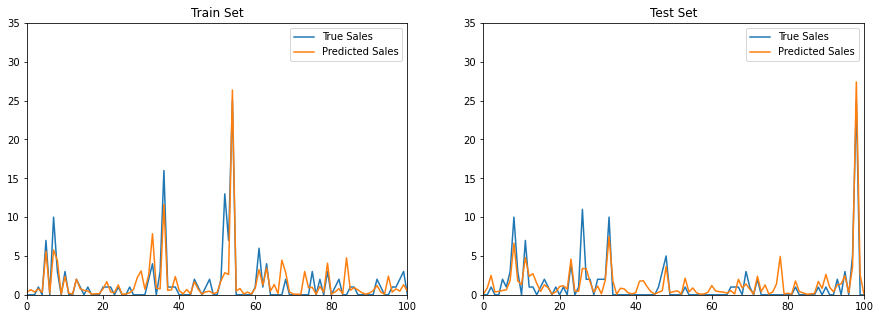

In [17]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.arange(len(y_train)), y_train, label='True Sales')
ax[0].plot(np.arange(len(preds_train)), preds_train, label='Predicted Sales')
ax[0].set_title("Train Set")
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,35)
ax[0].legend()

ax[1].plot(np.arange(len(y_test)), y_test, label='True Sales')
ax[1].plot(np.arange(len(preds_test)), preds_test, label='Predicted Sales')
ax[1].set_title("Test Set")
ax[1].set_xlim(0,100)
ax[1].set_ylim(0,35)
ax[1].legend()

plt.show()

# Hist Gradient Boosting Regressor

Its in sklearn and it says it is inspired from LightGBM so lets try it

In [18]:
# explicitly require this experimental feature
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import HistGradientBoostingRegressor

model=HistGradientBoostingRegressor()
model.fit(X_train, y_train)
preds_train=model.predict(X_train)
preds_test=model.predict(X_test)

In [19]:
print(f"MSE on train set: {mean_squared_error(preds_train,y_train)}")
print(f"MSE on test set: {mean_squared_error(preds_test,y_test)}")

MSE on train set: 5.051584632027662
MSE on test set: 6.010940927717325


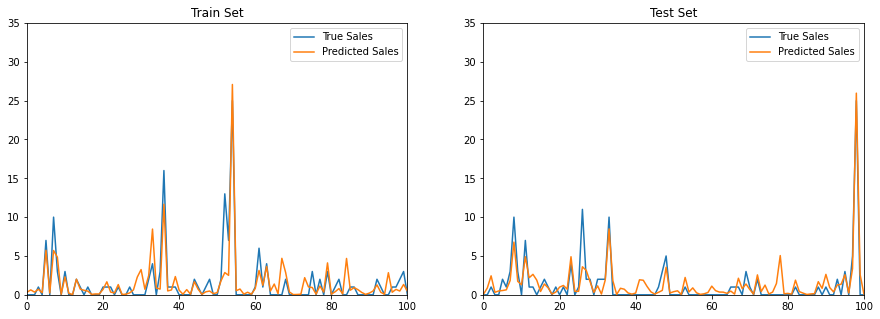

In [20]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].plot(np.arange(len(y_train)), y_train, label='True Sales')
ax[0].plot(np.arange(len(preds_train)), preds_train, label='Predicted Sales')
ax[0].set_title("Train Set")
ax[0].set_xlim(0,100)
ax[0].set_ylim(0,35)
ax[0].legend()

ax[1].plot(np.arange(len(y_test)), y_test, label='True Sales')
ax[1].plot(np.arange(len(preds_test)), preds_test, label='Predicted Sales')
ax[1].set_title("Test Set")
ax[1].set_xlim(0,100)
ax[1].set_ylim(0,35)
ax[1].legend()

plt.show()